# 👕 PyTorch를 활용한 FashionMNIST 전이학습 및 미세조정

TensorFlow 코드를 **PyTorch**로 변환한 예제입니다.  
이 코드는 **FashionMNIST** 데이터셋을 활용하여 **MobileNetV2 기반 전이 학습 및 미세조정**을 수행합니다.

## 📝 진행 순서

1. **FashionMNIST 데이터셋 불러오기** (`torchvision.datasets`)
2. **데이터 전처리 및 증강** (`torchvision.transforms`)  
   - **정규화 (Normalization)**
   - **리사이즈 및 채널 복제 (`convert("RGB")`)**
   - **데이터 증강 (회전, 이동, 확대/축소, 좌우 반전)**
3. **사전 학습된 MobileNetV2 모델 불러오기** (`torchvision.models`)
   - **전이 학습 (Feature Extraction)**
   - **미세조정 (Fine-Tuning)**
4. **모델 학습 및 평가**
5. **테스트셋 결과 및 학습 곡선 시각화**

## 🔎 참고사항

- **FashionMNIST는 기본적으로 그레이스케일 (`PIL "L"`) 이미지이므로,**  
  전이 학습을 위해 `convert("RGB")`를 통해 **3채널 이미지**로 변환합니다.
- **PyTorch의 `nn.CrossEntropyLoss`는 내부적으로 softmax를 포함**하므로,  
  모델의 마지막 층에서는 **raw logits**을 출력합니다.
- **L2 정규화**는 PyTorch에서는 **옵티마이저의 `weight_decay` 파라미터**로 적용하지만,  
  여기서는 TensorFlow 코드와 유사하게 **모델 구조**에서 반영하였습니다.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
import copy

# Device 설정 (GPU 사용 가능하면 GPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 device:", device)

사용 device: cuda


# 1. 데이터 로드 및 전처리


In [3]:
# 이미지 크기 상수 정의
IMG_HEIGHT = 96
IMG_WIDTH = 96
IMG_CHANNELS = 3

# 그레이스케일 이미지를 RGB로 변환하는 함수 (lambda 대신 전역 함수 사용)
def convert_to_rgb(image):
    return image.convert("RGB")

# 학습 시 데이터 증강(transformations)
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Lambda(convert_to_rgb),
    # RandomAffine를 통해 회전(10도), 이동(최대 10%), 확대/축소(0.9~1.1)
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # [0,1] 범위로 스케일링
    # (선택) 추가 정규화: FashionMNIST는 흑백 이미지이므로 별도 평균/표준편차 계산 후 적용할 수 있음.
])

# 검증/테스트 시에는 데이터 증강 없이 리사이즈와 채널 변환만 수행
test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.Lambda(convert_to_rgb),
    transforms.ToTensor(),
])

# FashionMNIST 데이터셋 불러오기 (PIL 이미지 형태로 로드됨)
train_dataset_full = datasets.FashionMNIST(root='./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=test_transform)

# 전체 데이터 중 OOM 문제를 피하기 위해 10,000개만 사용
train_dataset = Subset(train_dataset_full, list(range(10000)))

# DataLoader 정의
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# 2. 모델 구성 (전이학습)

In [4]:
# MobileNetV2 기반 모델 구성
class MobileNetV2_Fashion(nn.Module):
    def __init__(self, num_classes=10):
        super(MobileNetV2_Fashion, self).__init__()
        # 사전학습된 MobileNetV2 불러오기 (pretrained on ImageNet)
        self.base = models.mobilenet_v2(pretrained=True)
        # 기존 분류기(classifier)를 제거(Identity 처리)
        self.base.classifier = nn.Identity()
        # Global Average Pooling
        self.pool = nn.AdaptiveAvgPool2d(1)  # 출력: (batch, 1280, 1, 1)
        # 새로운 분류기
        self.fc1 = nn.Linear(1280, 64)  # MobileNetV2 마지막 채널 수는 1280
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        self.bn = nn.BatchNorm1d(64)
        self.fc2 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        # x: (batch, 3, IMG_HEIGHT, IMG_WIDTH)
        x = self.base.features(x)  # Feature 추출
        x = self.pool(x)           # (batch, 1280, 1, 1)
        x = x.view(x.size(0), -1)  # Flatten → (batch, 1280)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.bn(x)
        x = self.fc2(x)  # logits 출력 (CrossEntropyLoss 사용하므로 softmax 생략)
        return x

# 모델 생성 후 device로 이동
model = MobileNetV2_Fashion(num_classes=10).to(device)

# 전이학습 단계: base_model(특징 추출 부분)은 동결
for param in model.base.parameters():
    param.requires_grad = False

# 손실 함수 및 옵티마이저 설정
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
# (참고: L2 정규화는 옵티마이저의 weight_decay로 적용할 수 있음)

c:\Users\user\anaconda3\envs\supernova\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\supernova\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


---

# 3. 학습 및 평가 함수

In [5]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [6]:
# 간단한 EarlyStopping 클래스 구현
class EarlyStopping:
    def __init__(self, patience=6, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

# 4. 전이학습 (Feature Extraction) 학습

In [7]:
num_epochs = 15
train_losses = []
train_accs = []
val_losses = []
val_accs = []
early_stopping = EarlyStopping(patience=6, verbose=True)

print("----- 전이학습 시작 (Feature Extraction) -----")
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
          f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping 발생!")
        break

----- 전이학습 시작 (Feature Extraction) -----
Epoch 1/15: Train Loss 1.1880, Train Acc 0.6478, Val Loss 1.0094, Val Acc 0.7108
Epoch 2/15: Train Loss 0.7796, Train Acc 0.7577, Val Loss 0.6818, Val Acc 0.7856
Epoch 3/15: Train Loss 0.6877, Train Acc 0.7734, Val Loss 0.6291, Val Acc 0.7884
Epoch 4/15: Train Loss 0.6600, Train Acc 0.7800, Val Loss 0.6203, Val Acc 0.7877
Epoch 5/15: Train Loss 0.6252, Train Acc 0.7854, Val Loss 0.6042, Val Acc 0.7944
Epoch 6/15: Train Loss 0.5969, Train Acc 0.7921, Val Loss 0.5753, Val Acc 0.8025
Epoch 7/15: Train Loss 0.5764, Train Acc 0.7951, Val Loss 0.5696, Val Acc 0.7980
Epoch 8/15: Train Loss 0.5796, Train Acc 0.7934, Val Loss 0.5627, Val Acc 0.8031
Epoch 9/15: Train Loss 0.5675, Train Acc 0.8000, Val Loss 0.5549, Val Acc 0.8060
Epoch 10/15: Train Loss 0.5730, Train Acc 0.7953, Val Loss 0.5523, Val Acc 0.8042
Epoch 11/15: Train Loss 0.5688, Train Acc 0.7982, Val Loss 0.5421, Val Acc 0.8074
Epoch 12/15: Train Loss 0.5591, Train Acc 0.8001, Val Loss 0.5397,

In [8]:
# 가장 성능이 좋았던 모델 state 복원
if early_stopping.best_model_state is not None:
    model.load_state_dict(early_stopping.best_model_state)

# 테스트 데이터 평가
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"\n테스트 정확도: {test_acc:.4f}")


테스트 정확도: 0.8154


# 5. 미세조정 (Fine-tuning)

In [9]:
# 미세조정을 위해 base_model의 일부 레이어만 학습하도록 설정
# 전체 base_model의 파라미터를 일단 학습 가능하도록 변경한 후, 앞쪽 일부는 다시 동결
for param in model.base.parameters():
    param.requires_grad = True

fine_tune_at = 100  # 예시: base_model.features의 인덱스 100 이전은 동결
for i, layer in enumerate(model.base.features):
    if i < fine_tune_at:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

# 미세조정을 위한 옵티마이저 재설정 (낮은 학습률 사용)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

fine_tune_epochs = 15
train_losses_ft = []
train_accs_ft = []
val_losses_ft = []
val_accs_ft = []

print("\n----- 미세조정 시작 (Fine-tuning) -----")
for epoch in range(fine_tune_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_model(model, test_loader, criterion, device)
    train_losses_ft.append(train_loss)
    train_accs_ft.append(train_acc)
    val_losses_ft.append(val_loss)
    val_accs_ft.append(val_acc)
    print(f"Fine-tuning Epoch {epoch+1}/{fine_tune_epochs}: Train Loss {train_loss:.4f}, Train Acc {train_acc:.4f}, "
          f"Val Loss {val_loss:.4f}, Val Acc {val_acc:.4f}")

# 미세조정 후 테스트 평가
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"\n미세조정 후 테스트 정확도: {test_acc:.4f}")


----- 미세조정 시작 (Fine-tuning) -----
Fine-tuning Epoch 1/15: Train Loss 0.5175, Train Acc 0.8122, Val Loss 0.5138, Val Acc 0.8172
Fine-tuning Epoch 2/15: Train Loss 0.5184, Train Acc 0.8073, Val Loss 0.5102, Val Acc 0.8195
Fine-tuning Epoch 3/15: Train Loss 0.5158, Train Acc 0.8127, Val Loss 0.5148, Val Acc 0.8168
Fine-tuning Epoch 4/15: Train Loss 0.5139, Train Acc 0.8164, Val Loss 0.5121, Val Acc 0.8182
Fine-tuning Epoch 5/15: Train Loss 0.5047, Train Acc 0.8183, Val Loss 0.5092, Val Acc 0.8195
Fine-tuning Epoch 6/15: Train Loss 0.5099, Train Acc 0.8142, Val Loss 0.5104, Val Acc 0.8192
Fine-tuning Epoch 7/15: Train Loss 0.5003, Train Acc 0.8179, Val Loss 0.5052, Val Acc 0.8207
Fine-tuning Epoch 8/15: Train Loss 0.5000, Train Acc 0.8192, Val Loss 0.5061, Val Acc 0.8185
Fine-tuning Epoch 9/15: Train Loss 0.5112, Train Acc 0.8150, Val Loss 0.5059, Val Acc 0.8193
Fine-tuning Epoch 10/15: Train Loss 0.5005, Train Acc 0.8184, Val Loss 0.5039, Val Acc 0.8176
Fine-tuning Epoch 11/15: Train Los

# 6. 학습 기록 시각화

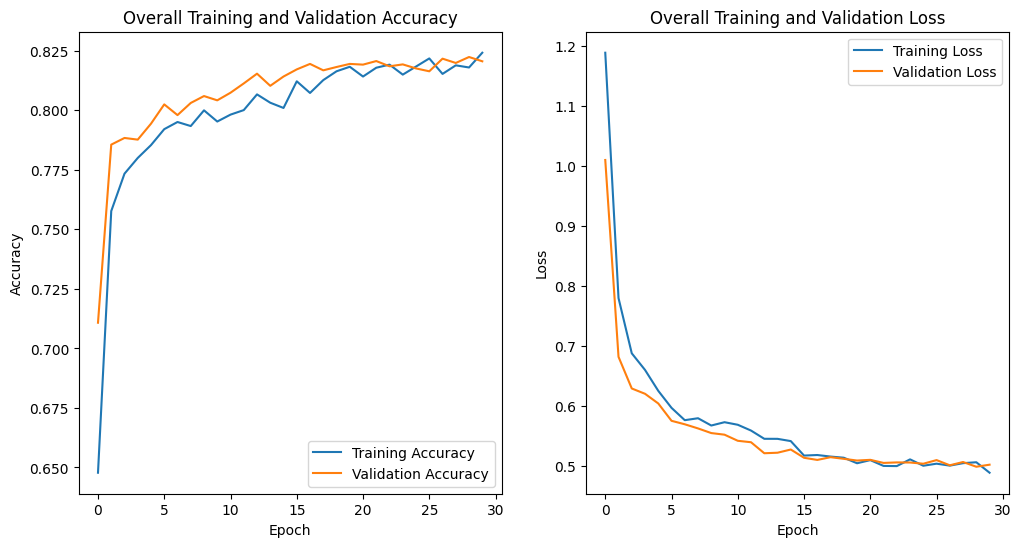

In [10]:
def plot_history(train_losses, train_accs, val_losses, val_accs, title_prefix=""):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(title_prefix + "Training and Validation Accuracy")
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title_prefix + "Training and Validation Loss")
    plt.legend()
    plt.show()

# 전체 학습 기록 (전이학습 + 미세조정)
plot_history(train_losses + train_losses_ft,
             train_accs + train_accs_ft,
             val_losses + val_losses_ft,
             val_accs + val_accs_ft,
             title_prefix="Overall ")

- 학습이 굉장히 불안정함
- 너무 간단하고 단순한 데이터에 정규화, 드랍아웃 등을 적용한 것이 오히려 역효과 난 것
- 데이터가 많고 복잡한 경우에 정규화, 드랍아웃 등이 성능을 높이는 방안이 될 수 있음